In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, Dataset
from tqdm.auto import tqdm, trange
import pylab as plt
import numpy.linalg as la

from common import gsave, gload, gopen, toTensors

def imshow(x):
    plt.imshow(x.squeeze() / 2.0 + 0.5, cmap='gray')
    
def flatten_np(X : torch.Tensor, Y: torch.Tensor):
    x = X.reshape(X.size(0), -1).numpy()
    y = F.one_hot(Y, 10).float().numpy()
    return x, y

transform = transforms.Compose([transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])
    
data = torchvision.datasets.FashionMNIST('~/data', train=True, download=True, transform=transform)
_X, _Y = toTensors(data)

ntrain = 50000
ntest = len(data)-ntrain
X, Y = flatten_np(_X, _Y)

X_tr, Y_tr = X[:ntrain], Y[:ntrain]
X_te, Y_te = X[ntrain:], Y[ntrain:]

In [10]:
def evaluate(beta, G, X : np.ndarray, Y: np.ndarray):
    outputs = emb(X, G).dot(beta)
    mse = la.norm(outputs - Y)**2 / X.shape[0]
    _, preds = torch.max(torch.Tensor(outputs), dim=1)
    _, Ytrue = torch.max(torch.Tensor(Y), dim=1)
    acc = (preds == Ytrue).float().mean().item()
    return mse, acc

def get_embed(d, D):
    G = np.random.randn(d, D) / np.sqrt(d)
    return G

def emb(X, G):
    def relu(x):
        return x*(x > 0)
    return relu(X.dot(G))

def solve_mse_reg(X, Y, G, lamb=0.1):
    eX = emb(X, G)
    M = la.inv(eX.T.dot(eX) + lamb*np.eye(eX.shape[1])).dot(eX.T)
    beta = M.dot(Y)
    return beta
    
def get_test_err_reg(n, D, lamb):
    I = np.random.permutation(len(X_tr))
    X, Y = X_tr[I], Y_tr[I]
    
    X, Y = X[:n], Y[:n]
    n, d = X.shape
    G = get_embed(d, D)

    beta = solve_mse_reg(X, Y, G, lamb)
    #mse_tr, acc_tr = evaluate(beta, G, X, Y)
    mse_te, acc_te = evaluate(beta, G, X_te, Y_te)

    return (1-acc_te), mse_te

def expected_err(n, D, lamb, ntrials=10):
    avg_err = 0
    avg_mse = 0
    for _ in range(ntrials):
        err, mse = get_test_err_reg(n, D, lamb)
        avg_err += err
        avg_mse += mse
    return avg_err / ntrials, avg_mse / ntrials

In [ ]:
ns = list(range(1, 1000, 20))
facts = np.array(list(range(-22, 4, 2)) )

lambda0 = 500
lambs = [lambda0 * (2.0)**i for i in facts]


errs = np.empty((len(lambs), len(ns)))
mses = np.empty((len(lambs), len(ns)))

for i, n in enumerate(tqdm(ns)):
    for j, lamb in enumerate(lambs):
        err, mse = expected_err(n, D=500, lamb=lamb, ntrials=10)
        errs[j, i] = err
        mses[j, i] = mse
        
gsave((errs, mses, lambs, facts, ns), 'gs://preetum/results/sdd/plots/fmnist_samps')

Text(0.5, 1.0, 'Test Error vs. Num Samples for Random ReLU features (500 features) regularized-regression.')

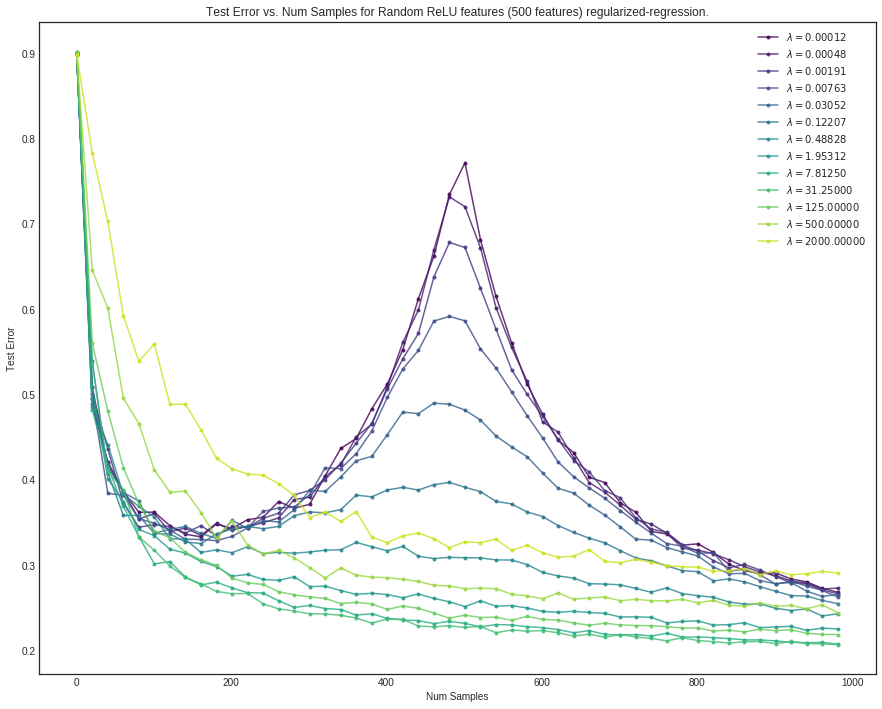

In [13]:
### Plot

cm=plt.get_cmap('viridis')
plt.style.use('seaborn-white')
plt.figure(figsize=(15, 12))

for i in range(len(lambs)):
    plt.plot(ns, errs[i, :], '.-',
             color=cm(i / (len(lambs)) ),
             alpha= 0.8,
             label='$\lambda = {%0.5f}$' % lambs[i])

plt.legend()
#plt.ylim(0, 2)
plt.xlabel('Num Samples')
plt.ylabel('Test Error')
plt.title('Test Error vs. Num Samples for Random ReLU features (500 features) regularized-regression.')